# 02 - Feature Engineering & Data Cleaning

**Objectif** : Nettoyer les données, créer de nouvelles variables (features) et préparer les données pour la modélisation.

---

## Programme du notebook :
1. Charger les données
2. **Nettoyage des données** (NaN, valeurs saturées)
3. Créer des features temporelles (jour de l'année, saison)
4. Créer de nouveaux indices spectraux (ratios)
5. **Preprocessing** (normalisation, one-hot encoding)
6. Visualisation des données finales
7. Préparer les données de submission

---

## Stratégie de nettoyage :

| Dataset | Stratégie | Raison |
|---------|-----------|--------|
| **Training** | Supprimer NaN + saturées | On a assez de données (~8000 lignes) |
| **Submission** | Imputer par médiane | On doit prédire les 200 lignes |

## Stratégie de preprocessing :

| Transformation | Méthode | Application |
|----------------|---------|-------------|
| **Normalisation** | StandardScaler | Fit sur training, transform sur les deux |
| **Catégoriel** | One-Hot Encoding (`drop_first=True`) | `season` → 3 colonnes (évite multicolinéarité) |
| **Suppression** | Drop colonnes inutiles | `season`, `Sample Date` |

---
## 1. Imports et chargement

In [ ]:
# Imports de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn pour le preprocessing
from sklearn.preprocessing import StandardScaler

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (10, 6)

# Pour ignorer les warnings
import warnings
warnings.filterwarnings('ignore')

# Accéder au dossier src/
import sys
sys.path.append('..')

from src.paths import (
    WATER_QUALITY_FILE, LANDSAT_FILE, TERRACLIMATE_FILE,
    SUBMISSION_TEMPLATE, LANDSAT_SUBMISSION_FILE, TERRACLIMATE_SUBMISSION_FILE
)
from src.data.load_data import load_all, load_submission
from src.config import TARGETS, ALL_FEATURES, LANDSAT_BANDS, LANDSAT_INDICES

print("Imports OK!")

In [2]:
# Charger les données (SANS nettoyage pour voir l'état brut)
X, y, site_ids, df = load_all(
    str(WATER_QUALITY_FILE),
    str(LANDSAT_FILE),
    str(TERRACLIMATE_FILE),
    features=ALL_FEATURES,
    fill_na=False  # On ne remplit PAS les NaN pour l'instant
)

print(f"\nColonnes disponibles: {list(df.columns)}")

CHARGEMENT DES DONNÉES
[OK] Water quality: 9319 lignes
[OK] Landsat: 9319 lignes, 13 colonnes
[OK] TerraClimate: 9319 lignes
[OK] Données fusionnées: 9319 lignes, 26 colonnes

Valeurs manquantes:

10 colonnes avec des valeurs manquantes:
  - blue: 1371 manquants (14.7%)
  - green: 814 manquants (8.7%)
  - red: 1371 manquants (14.7%)
  - nir: 814 manquants (8.7%)
  - swir16: 814 manquants (8.7%)
  - swir22: 814 manquants (8.7%)
  - NDVI: 1371 manquants (14.7%)
  - NDWI: 814 manquants (8.7%)
  - NDMI: 814 manquants (8.7%)
  - MNDWI: 814 manquants (8.7%)
[OK] 162 sites uniques identifiés
[OK] X: 9319 lignes, 11 features
[OK] y: 9319 lignes, 3 targets

PRÊT!

Colonnes disponibles: ['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus', 'blue', 'green', 'red', 'nir', 'swir16', 'swir22', 'NDVI', 'NDWI', 'NDMI', 'MNDWI', 'pet', 'aet', 'ppt', 'tmax', 'tmin', 'soil', 'def', 'pdsi', 'vpd', 'ws']


---
## 2. Nettoyage des données (Training)

### Étapes :
1. Supprimer les lignes avec valeurs manquantes (NaN)
2. Supprimer les valeurs saturées Landsat (65535)
3. Calculer les médianes pour l'imputation du submission

In [3]:
# =============================================================================
# 2.1 État initial et nettoyage
# =============================================================================

print("=" * 60)
print("NETTOYAGE DES DONNÉES TRAINING")
print("=" * 60)

# Constante pour les valeurs saturées
SATURATION_VALUE = 65535

# État initial
print(f"\nÉtat initial: {len(df)} lignes")
n_nan = df[ALL_FEATURES].isna().any(axis=1).sum()
print(f"  - Lignes avec NaN: {n_nan} ({100*n_nan/len(df):.1f}%)")
saturated_mask = (df[LANDSAT_BANDS] == SATURATION_VALUE).any(axis=1)
n_saturated = saturated_mask.sum()
print(f"  - Lignes avec valeurs saturées (65535): {n_saturated}")

# Nettoyage
df_clean = df.copy()

# Étape 1: Supprimer les NaN
before = len(df_clean)
df_clean = df_clean.dropna(subset=ALL_FEATURES)
print(f"\n1. Suppression NaN: {before} -> {len(df_clean)} lignes")

# Étape 2: Supprimer les valeurs saturées
before = len(df_clean)
saturated_mask = (df_clean[LANDSAT_BANDS] == SATURATION_VALUE).any(axis=1)
df_clean = df_clean[~saturated_mask]
print(f"2. Suppression saturées: {before} -> {len(df_clean)} lignes")

# Résultat
print(f"\n" + "=" * 60)
print(f"RÉSULTAT: {len(df_clean)} lignes ({100*len(df_clean)/len(df):.1f}% conservé)")
print("=" * 60)

NETTOYAGE DES DONNÉES TRAINING

État initial: 9319 lignes
  - Lignes avec NaN: 1371 (14.7%)
  - Lignes avec valeurs saturées (65535): 16

1. Suppression NaN: 9319 -> 7948 lignes
2. Suppression saturées: 7948 -> 7932 lignes

RÉSULTAT: 7932 lignes (85.1% conservé)


In [4]:
# =============================================================================
# 2.2 Calculer les médianes pour l'imputation (submission)
# =============================================================================

# On calcule les médianes sur le dataset NETTOYÉ
# Ces médianes seront utilisées pour imputer les valeurs manquantes du submission

medians = df_clean[ALL_FEATURES].median()

print("Médianes calculées (pour imputation submission):")
print("-" * 50)
for feature in ALL_FEATURES:
    print(f"  {feature}: {medians[feature]:.2f}")

# On continue à travailler avec df_clean pour le reste du notebook
df = df_clean.copy()
print(f"\n--> On travaille maintenant avec df_clean ({len(df)} lignes)")

Médianes calculées (pour imputation submission):
--------------------------------------------------
  blue: 8871.50
  green: 9808.00
  red: 10125.00
  nir: 14160.50
  swir16: 13746.50
  swir22: 11303.75
  NDVI: 0.14
  NDWI: -0.17
  NDMI: 0.02
  MNDWI: -0.17
  pet: 118.60

--> On travaille maintenant avec df_clean (7932 lignes)


---
## 3. Features temporelles

**Pourquoi ?** La qualité de l'eau varie selon les saisons (pluie, température, etc.)

**Features retenues :**
- `day_of_year` : position dans l'année (1-365), capture la saisonnalité fine
- `season` : saison (4 catégories), plus simple pour le modèle

In [5]:
# Extraire le jour de l'année (1-365)
df['day_of_year'] = df['Sample Date'].dt.dayofyear

# Créer une variable "saison" (hémisphère sud)
def get_season(date):
    month = date.month
    if month in [12, 1, 2]: return 'summer'
    elif month in [3, 4, 5]: return 'autumn'
    elif month in [6, 7, 8]: return 'winter'
    else: return 'spring'

df['season'] = df['Sample Date'].apply(get_season)

print("Features temporelles créées:")
print(f"  - day_of_year: {df['day_of_year'].min()} à {df['day_of_year'].max()}")
print(f"  - season: {df['season'].value_counts().to_dict()}")

Features temporelles créées:
  - day_of_year: 1 à 365
  - season: {'winter': 2203, 'spring': 2122, 'autumn': 2117, 'summer': 1490}


---
## 4. Corrélation des features Landsat avec les targets

On a maintenant toutes les features Landsat disponibles (6 bandes + 4 indices).

In [6]:
# Quelles features Landsat sont disponibles ?
print("Features Landsat disponibles :")
landsat_features = LANDSAT_BANDS + LANDSAT_INDICES
for f in landsat_features:
    if f in df.columns:
        print(f"  - {f} : OK")
    else:
        print(f"  - {f} : MANQUANTE")

Features Landsat disponibles :
  - blue : OK
  - green : OK
  - red : OK
  - nir : OK
  - swir16 : OK
  - swir22 : OK
  - NDVI : OK
  - NDWI : OK
  - NDMI : OK
  - MNDWI : OK


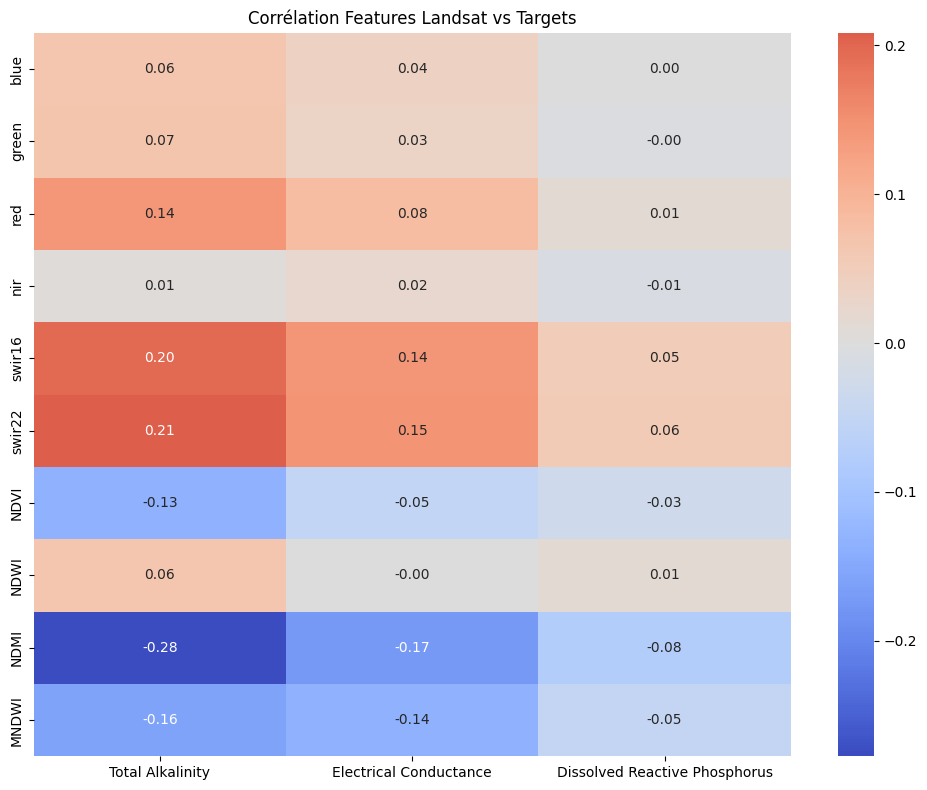

In [7]:
# Corrélation des features Landsat avec les targets
landsat_in_df = [f for f in landsat_features if f in df.columns]

corr = df[landsat_in_df + TARGETS].corr()
corr_subset = corr.loc[landsat_in_df, TARGETS]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Corrélation Features Landsat vs Targets')
plt.tight_layout()
plt.show()

---
## 5. Créer de nouveaux ratios spectraux

Les ratios entre bandes peuvent capturer des informations sur la turbidité, la chlorophylle, etc.

Feature 'nir_green_ratio' créée!
Feature 'swir_ratio' créée!


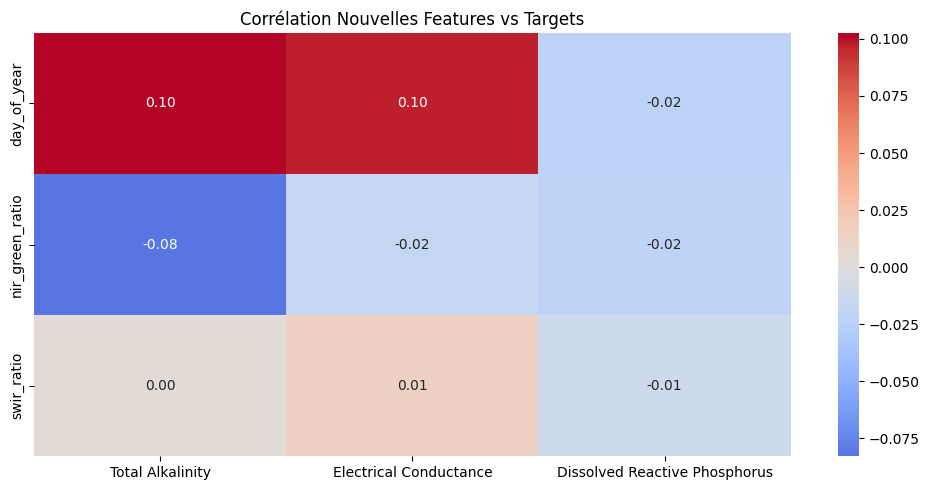

In [8]:
# Créer des ratios spectraux
if 'nir' in df.columns and 'green' in df.columns:
    df['nir_green_ratio'] = df['nir'] / (df['green'] + 0.0001)
    print("Feature 'nir_green_ratio' créée!")

if 'swir16' in df.columns and 'swir22' in df.columns:
    df['swir_ratio'] = df['swir16'] / (df['swir22'] + 0.0001)
    print("Feature 'swir_ratio' créée!")

# Corrélation des nouvelles features avec les targets
new_features = ['day_of_year', 'nir_green_ratio', 'swir_ratio']
new_features = [f for f in new_features if f in df.columns]

if new_features:
    corr = df[new_features + TARGETS].corr()
    corr_subset = corr.loc[new_features, TARGETS]
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Corrélation Nouvelles Features vs Targets')
    plt.tight_layout()
    plt.show()

---
## 6. Fonction réutilisable pour créer les features

In [9]:
def create_features(df):
    """
    Crée toutes les features supplémentaires.
    
    Features temporelles :
    - day_of_year : jour de l'année (1-365)
    - season : saison (summer, autumn, winter, spring)
    
    Features spectrales :
    - nir_green_ratio : ratio NIR/Green
    - swir_ratio : ratio SWIR16/SWIR22
    
    Paramètres:
        df : DataFrame avec les données brutes
    
    Retourne:
        DataFrame avec les nouvelles features
    """
    df = df.copy()
    
    # Features temporelles
    if 'Sample Date' in df.columns:
        # Jour de l'année (1-365)
        df['day_of_year'] = df['Sample Date'].dt.dayofyear
        
        # Saison (hémisphère sud)
        def get_season(date):
            month = date.month
            if month in [12, 1, 2]: return 'summer'
            elif month in [3, 4, 5]: return 'autumn'
            elif month in [6, 7, 8]: return 'winter'
            else: return 'spring'
        
        df['season'] = df['Sample Date'].apply(get_season)
    
    # Ratios spectraux
    if 'nir' in df.columns and 'green' in df.columns:
        df['nir_green_ratio'] = df['nir'] / (df['green'] + 0.0001)
    
    if 'swir16' in df.columns and 'swir22' in df.columns:
        df['swir_ratio'] = df['swir16'] / (df['swir22'] + 0.0001)
    
    return df

print("Fonction create_features() définie!")
print("\nFeatures créées par cette fonction :")
print("  - day_of_year (temporelle)")
print("  - season (temporelle)")
print("  - nir_green_ratio (spectrale)")
print("  - swir_ratio (spectrale)")

Fonction create_features() définie!

Features créées par cette fonction :
  - day_of_year (temporelle)
  - season (temporelle)
  - nir_green_ratio (spectrale)
  - swir_ratio (spectrale)


---
## 7. Preprocessing (Normalisation & One-Hot Encoding)

### Pourquoi normaliser ?
- Les features ont des échelles très différentes (ex: bandes Landsat ~10000, indices ~0.1)
- La normalisation améliore la convergence des modèles (régression, SVM, réseaux de neurones)
- On utilise `StandardScaler` : centre sur 0, écart-type de 1

### One-Hot Encoding
- La variable `season` est catégorielle (4 valeurs : summer, autumn, winter, spring)
- On utilise `drop_first=True` pour éviter la **multicolinéarité** (dummy variable trap)
- Résultat : 3 colonnes binaires au lieu de 4 (la 4ème catégorie "autumn" est la référence)

### Colonnes supprimées
- `season` : remplacée par les dummies
- `Sample Date` : déjà utilisée pour créer `day_of_year`

**Important** : Le scaler est **fit sur le training uniquement** pour éviter le data leakage.

In [ ]:
# =============================================================================
# 7.1 Définir les features à normaliser
# =============================================================================

# Features numériques à normaliser (toutes sauf season qui est catégorielle)
NUMERIC_FEATURES = ALL_FEATURES + ['day_of_year', 'nir_green_ratio', 'swir_ratio']

print("Features numériques à normaliser:")
for f in NUMERIC_FEATURES:
    if f in df.columns:
        print(f"  - {f}: min={df[f].min():.2f}, max={df[f].max():.2f}")

# =============================================================================
# 7.2 One-Hot Encoding de la variable 'season'
# =============================================================================

print("\n" + "=" * 60)
print("ONE-HOT ENCODING")
print("=" * 60)

# Créer les dummies pour season avec drop_first=True pour éviter la multicolinéarité
# dtype=int pour avoir des 0/1 au lieu de True/False
season_dummies = pd.get_dummies(df['season'], prefix='season', drop_first=True, dtype=int)
print(f"\nVariable 'season' encodée en {len(season_dummies.columns)} colonnes (drop_first=True):")
for col in season_dummies.columns:
    print(f"  - {col}: {season_dummies[col].sum()} lignes à 1")
print(f"  (La catégorie de référence 'autumn' est implicite quand toutes les autres sont à 0)")

# Ajouter les dummies au DataFrame
df = pd.concat([df, season_dummies], axis=1)

# Supprimer la colonne season originale (plus nécessaire)
df = df.drop(columns=['season'])
print(f"\n[OK] Colonne 'season' originale supprimée")

# Supprimer Sample Date (déjà utilisé pour créer day_of_year)
df = df.drop(columns=['Sample Date'])
print("[OK] Colonne 'Sample Date' supprimée")

# Liste des colonnes season pour le preprocessing du submission
SEASON_COLUMNS = list(season_dummies.columns)
print(f"\nColonnes season finales: {SEASON_COLUMNS}")
print(f"Type des colonnes: {season_dummies.dtypes.unique()}")

In [ ]:
# =============================================================================
# 7.3 Normalisation avec StandardScaler
# =============================================================================

print("=" * 60)
print("NORMALISATION (StandardScaler)")
print("=" * 60)

# Créer et fit le scaler sur les données d'entraînement
scaler = StandardScaler()
scaler.fit(df[NUMERIC_FEATURES])

print("\nScaler fitted sur le training set!")
print(f"  - Nombre de features: {len(NUMERIC_FEATURES)}")

# Transformer les données d'entraînement
df_scaled = df.copy()
df_scaled[NUMERIC_FEATURES] = scaler.transform(df[NUMERIC_FEATURES])

print("\nAprès normalisation (échantillon de features):")
print("-" * 50)
sample_features = ['blue', 'NDVI', 'pet', 'day_of_year']
for f in sample_features:
    if f in df_scaled.columns:
        print(f"  {f}: mean={df_scaled[f].mean():.4f}, std={df_scaled[f].std():.4f}")

print("\n[OK] Données d'entraînement normalisées!")

---
## 8. Visualisation des données preprocessées

Aperçu des données après toutes les transformations.

In [ ]:
# =============================================================================
# 8.1 Aperçu du DataFrame final (Training)
# =============================================================================

print("=" * 70)
print("APERÇU DU DATAFRAME FINAL (Training - Normalisé)")
print("=" * 70)

print(f"\nDimensions: {df_scaled.shape[0]} lignes x {df_scaled.shape[1]} colonnes")

# Séparer les types de colonnes
print(f"\nColonnes par type:")
print(f"  - Features numériques normalisées: {len(NUMERIC_FEATURES)}")
print(f"  - Features catégorielles (dummies): {len(SEASON_COLUMNS)}")
print(f"  - Autres (targets, metadata): {len(df_scaled.columns) - len(NUMERIC_FEATURES) - len(SEASON_COLUMNS)}")

print("\n" + "-" * 70)
print("STATISTIQUES DES FEATURES NORMALISÉES (échantillon):")
print("-" * 70)
df_scaled[sample_features].describe().round(2)

In [ ]:
# Visualisation de la distribution avant/après normalisation
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for idx, feature in enumerate(sample_features):
    ax = axes[idx // 2, idx % 2]
    
    # Avant normalisation
    ax.hist(df[feature], bins=50, alpha=0.5, label='Avant', color='blue')
    
    # Après normalisation (échelle différente, on superpose pas)
    ax2 = ax.twinx()
    ax2.hist(df_scaled[feature], bins=50, alpha=0.5, label='Après', color='orange')
    
    ax.set_title(f'{feature}')
    ax.set_xlabel('Valeur')
    ax.set_ylabel('Avant (bleu)', color='blue')
    ax2.set_ylabel('Après (orange)', color='orange')

plt.suptitle('Distribution avant/après normalisation', fontsize=14)
plt.tight_layout()
plt.show()

---
## 9. Préparation des données de Submission

On applique le **même preprocessing** au dataset de submission :
1. Charger les données
2. Imputer les valeurs manquantes (médiane du training)
3. Créer les features (temporelles + ratios)
4. One-hot encoding de `season`
5. Normaliser avec le **scaler déjà fitté** sur le training

In [ ]:
# =============================================================================
# 9.1 Charger les données de submission
# =============================================================================

print("=" * 60)
print("CHARGEMENT DES DONNÉES DE SUBMISSION")
print("=" * 60)

X_sub, df_sub = load_submission(
    str(SUBMISSION_TEMPLATE),
    str(LANDSAT_SUBMISSION_FILE),
    str(TERRACLIMATE_SUBMISSION_FILE),
    features=ALL_FEATURES,
    fill_na=False  # On impute manuellement avec nos médianes
)

print(f"\nValeurs manquantes avant traitement:")
missing = df_sub[ALL_FEATURES].isna().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    for col, n in missing_cols.items():
        print(f"  - {col}: {n} valeurs manquantes")
else:
    print("  Aucune valeur manquante!")

In [ ]:
# =============================================================================
# 9.2 Imputation des valeurs manquantes (avec médianes du training)
# =============================================================================

print("=" * 60)
print("IMPUTATION DES VALEURS MANQUANTES")
print("=" * 60)

df_sub_processed = df_sub.copy()

for feature in ALL_FEATURES:
    if df_sub_processed[feature].isna().any():
        n_missing = df_sub_processed[feature].isna().sum()
        df_sub_processed[feature] = df_sub_processed[feature].fillna(medians[feature])
        print(f"  {feature}: {n_missing} valeurs imputées (médiane = {medians[feature]:.2f})")

print(f"\n[OK] Imputation terminée - {df_sub_processed[ALL_FEATURES].isna().sum().sum()} valeurs manquantes restantes")

In [ ]:
# =============================================================================
# 9.3 Créer les features (temporelles + ratios)
# =============================================================================

print("=" * 60)
print("CREATION DES FEATURES")
print("=" * 60)

# Appliquer la fonction create_features pour créer day_of_year, season, ratios
df_sub_processed = create_features(df_sub_processed)

print("[OK] Features créées:")
print(f"  - day_of_year: {df_sub_processed['day_of_year'].min()} à {df_sub_processed['day_of_year'].max()}")
print(f"  - season: {df_sub_processed['season'].value_counts().to_dict()}")
print(f"  - nir_green_ratio: OK")
print(f"  - swir_ratio: OK")

In [ ]:
# =============================================================================
# 9.4 One-Hot Encoding de season (submission)
# =============================================================================

print("=" * 60)
print("ONE-HOT ENCODING (Submission)")
print("=" * 60)

# Créer les dummies pour season avec drop_first=True et dtype=int (même que training)
sub_season_dummies = pd.get_dummies(df_sub_processed['season'], prefix='season', drop_first=True, dtype=int)

# S'assurer que toutes les colonnes du training sont présentes
for col in SEASON_COLUMNS:
    if col not in sub_season_dummies.columns:
        sub_season_dummies[col] = 0
        print(f"  [!] Colonne {col} ajoutée (absente dans submission)")

# Garder seulement les colonnes du training et dans le même ordre
sub_season_dummies = sub_season_dummies[SEASON_COLUMNS]

# Ajouter au DataFrame
df_sub_processed = pd.concat([df_sub_processed, sub_season_dummies], axis=1)

# Supprimer les colonnes inutiles
df_sub_processed = df_sub_processed.drop(columns=['season'])
print("[OK] Colonne 'season' originale supprimée")

df_sub_processed = df_sub_processed.drop(columns=['Sample Date'])
print("[OK] Colonne 'Sample Date' supprimée")

print(f"\n[OK] One-hot encoding appliqué (drop_first=True, dtype=int):")
for col in SEASON_COLUMNS:
    print(f"  - {col}: {df_sub_processed[col].sum()} lignes à 1")

In [ ]:
# =============================================================================
# 9.5 Normalisation (avec le scaler du training)
# =============================================================================

print("=" * 60)
print("NORMALISATION (Submission)")
print("=" * 60)

# Transformer avec le scaler DÉJÀ FITTÉ sur le training
df_sub_scaled = df_sub_processed.copy()
df_sub_scaled[NUMERIC_FEATURES] = scaler.transform(df_sub_processed[NUMERIC_FEATURES])

print("[OK] Données de submission normalisées avec le scaler du training!")
print(f"\nAperçu après normalisation:")
print("-" * 50)
for f in sample_features:
    if f in df_sub_scaled.columns:
        print(f"  {f}: mean={df_sub_scaled[f].mean():.4f}, std={df_sub_scaled[f].std():.4f}")

---
## 10. Résumé

### Données préparées :

| Dataset | Variable | Lignes | Description |
|---------|----------|--------|-------------|
| **Training** | `df_scaled` | ~7900 | Nettoyé + features + normalisé |
| **Submission** | `df_sub_scaled` | 200 | Imputé + features + normalisé |

### Pipeline de preprocessing appliqué :

| Étape | Training | Submission |
|-------|----------|------------|
| 1. Nettoyage NaN | Suppression | Imputation (médiane) |
| 2. Valeurs saturées | Suppression | - |
| 3. Features temporelles | `day_of_year`, `season` | Idem |
| 4. Ratios spectraux | `nir_green_ratio`, `swir_ratio` | Idem |
| 5. One-Hot Encoding | `season` → 3 colonnes (`drop_first=True`) | Idem |
| 6. Normalisation | **Fit** + Transform | Transform seulement |
| 7. Suppression colonnes | `season`, `Sample Date` | Idem |

### Features finales :

| Type | Features | Count |
|------|----------|-------|
| **Landsat bandes** | blue, green, red, nir, swir16, swir22 | 6 |
| **Landsat indices** | NDVI, NDWI, NDMI, MNDWI | 4 |
| **TerraClimate** | pet, aet, ppt, tmax, tmin, soil, def, pdsi, vpd, ws | 10 |
| **Temporelles** | day_of_year | 1 |
| **Ratios** | nir_green_ratio, swir_ratio | 2 |
| **Catégorielles (dummies)** | season_spring, season_summer, season_winter | 3 |
| **Total** | | **26** |

> **Note** : On utilise `drop_first=True` pour éviter la multicolinéarité. La catégorie "autumn" est la référence (implicite quand les 3 autres sont à 0).

### Prochaine étape :

**Notebook 03 : Modélisation** - Entraîner et évaluer des modèles sur les données preprocessées

In [ ]:
# =============================================================================
# 10.1 Résumé final
# =============================================================================

print("=" * 70)
print("RESUME FINAL")
print("=" * 70)

print(f"\n[TRAINING SET] df_scaled:")
print(f"   - Lignes: {len(df_scaled)}")
print(f"   - Colonnes: {len(df_scaled.columns)}")
print(f"   - Features numeriques normalisees: {len(NUMERIC_FEATURES)}")
print(f"   - Features categorielles (dummies): {len(SEASON_COLUMNS)}")

print(f"\n[SUBMISSION SET] df_sub_scaled:")
print(f"   - Lignes: {len(df_sub_scaled)}")
print(f"   - Colonnes: {len(df_sub_scaled.columns)}")

print(f"\n[OBJETS SAUVEGARDES POUR LA MODELISATION]:")
print(f"   - scaler: StandardScaler fitte sur le training")
print(f"   - medians: Medianes pour l'imputation")
print(f"   - NUMERIC_FEATURES: Liste des {len(NUMERIC_FEATURES)} features numeriques")
print(f"   - SEASON_COLUMNS: Liste des {len(SEASON_COLUMNS)} colonnes dummies")

print("\n" + "=" * 70)
print("PRET POUR LA MODELISATION!")
print("=" * 70)